In [ ]:
import os
import librosa
import math
import json
import numpy as np
from sklearn.model_selection import train_test_split
import glob, random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import math
import librosa
import random

# Set your data path
DATASET_PATH = "/content/drive/MyDrive/genres_original"
JSON_PATH = "/content/drive/MyDrive/data_80.json"
SAMPLE_RATE = 22050
duration = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * duration


def save_melspec(dataset_path, json_path, n_fft=2048, hop_length=512, num_segments=40, n_mels=128):
    data = {
        "mapping": [],
        "mels": [],
        "labels": []
    }
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mel_vectors_per_segments = math.ceil(num_samples_per_segment / hop_length)

    # Genres and number of files to randomly select for each genre
    genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
    num_files_per_genre = 80

    for genre in genres:
        # Get filenames for the current genre
        genre_path = os.path.join(dataset_path, genre)
        filenames = os.listdir(genre_path)

        # Randomly select files for this genre
        selected_files = random.sample(filenames, num_files_per_genre)

        # Add the genre to the mapping
        data["mapping"].append(genre)

        print("\nProcessing {}...".format(genre))

        for filename in selected_files:
            file_path = os.path.join(genre_path, filename)
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Process segments extracting mels and storing data
            for s in range(num_segments):
                start_sample = num_samples_per_segment * s
                finish_sample = start_sample + num_samples_per_segment

                # Extract Mel spectrogram
                mels = librosa.feature.melspectrogram(y=signal[start_sample:finish_sample],
                                                      sr=SAMPLE_RATE,
                                                      n_fft=n_fft,
                                                      n_mels=n_mels,
                                                      hop_length=hop_length)
                mels = mels.T

                # Check if the number of Mel vectors matches the expected number
                if len(mels) == expected_num_mel_vectors_per_segments:
                    data["mels"].append(mels.tolist())
                    data["labels"].append(len(data["mapping"]) - 1)
                    print("Processed {}, segment: {}".format(filename, s))

    # Save data to JSON file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    save_melspec(DATASET_PATH, JSON_PATH, num_segments=20)


Streaming output truncated to the last 5000 lines.
Processed metal.00054.wav, segment: 6
Processed metal.00054.wav, segment: 7
Processed metal.00054.wav, segment: 8
Processed metal.00054.wav, segment: 9
Processed metal.00054.wav, segment: 10
Processed metal.00054.wav, segment: 11
Processed metal.00054.wav, segment: 12
Processed metal.00054.wav, segment: 13
Processed metal.00054.wav, segment: 14
Processed metal.00054.wav, segment: 15
Processed metal.00054.wav, segment: 16
Processed metal.00054.wav, segment: 17
Processed metal.00054.wav, segment: 18
Processed metal.00054.wav, segment: 19
Processed metal.00085.wav, segment: 0
Processed metal.00085.wav, segment: 1
Processed metal.00085.wav, segment: 2
Processed metal.00085.wav, segment: 3
Processed metal.00085.wav, segment: 4
Processed metal.00085.wav, segment: 5
Processed metal.00085.wav, segment: 6
Processed metal.00085.wav, segment: 7
Processed metal.00085.wav, segment: 8
Processed metal.00085.wav, segment: 9
Processed metal.00085.wav, 

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/data_80.json"


def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mels"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test








In [ ]:
def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64, (3, 3), activation='sigmoid'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))



#     # Flatten the output of the last convolutional layer
    model.add(keras.layers.GlobalMaxPooling2D())

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.1))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:

if __name__ == "__main__":
    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

#     # Reshape input data to include batch and channel dimensions
#     X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#     X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1) # Add channel dimension



In [ ]:
import tensorflow.keras as kf


model = build_model(input_shape)

    # compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',

                  metrics=['accuracy'])


model.summary()

    # train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=16, epochs=100)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 63, 126, 64)       640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 63, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 32, 63, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 61, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 31, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
model.evaluate(X_test,y_test)

125/125 [==============================] - 1s 4ms/step - loss: 0.9218 - accuracy: 0.6900


[0.9217951893806458, 0.6899999976158142]

In [ ]:
model.evaluate(X_train,y_train)

300/300 [==============================] - 2s 5ms/step - loss: 0.5612 - accuracy: 0.8484


[0.5611996054649353, 0.8484216928482056]

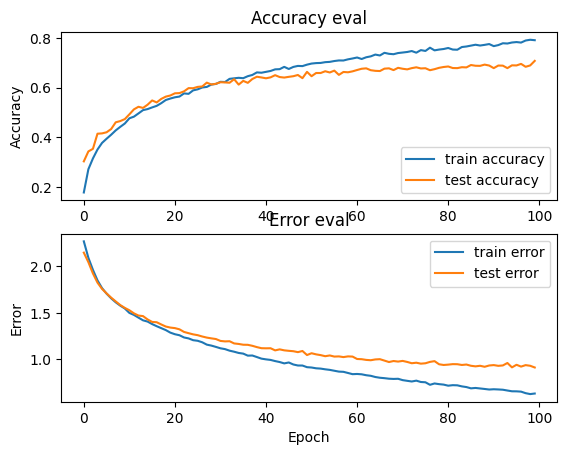

In [ ]:
# plot accuracy/error for training and validation
plot_history(history)

In [ ]:
model.save("/content/drive/MyDrive/Model_Multiclass_80.keras")

In [ ]:
import os
import librosa
import math
import json
import numpy as np
from sklearn.model_selection import train_test_split
import glob, random

SAMPLE_RATE = 22050
duration = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * duration
class_names = {
    0: "blues",
    1: "classical",
    2: "country",
    3: "disco",
    4: "hiphop",
    5: "jazz",
    6: "metal",
    7: "pop",
    8: "reggae",
    9: "rock"
}
# Load the trained model
model_path = "/content/drive/MyDrive/Model_Multiclass_80.keras"
model = keras.models.load_model(model_path)

# Function to extract Mel spectrogram features from audio file
def extract_mel_spectrogram(audio_file,n_fft=2048, hop_length=512, num_segments=20, n_mels=128):
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mel_vectors_per_segments = math.ceil(num_samples_per_segment / hop_length)

    y, sr = librosa.load(audio_file, sr=None)  # Load audio file

    for s in range(num_segments):
                start_sample = num_samples_per_segment * s
                finish_sample = start_sample + num_samples_per_segment

                # Extract Mel spectrogram
                mels= librosa.feature.melspectrogram(y=y[start_sample:finish_sample],
                                                      sr=SAMPLE_RATE,
                                                      n_fft=n_fft,
                                                      n_mels=n_mels,
                                                      hop_length=hop_length)
                mels= mels.T


    return mels

# Function to predict class labels for an input audio file
def predict_audio_class(audio_file, model):
    # Extract Mel spectrogram features
    mel_spectrogram = extract_mel_spectrogram(audio_file,num_segments=20)

    # Reshape the features to match the input shape of the model
    mel_spectrogram_reshaped = mel_spectrogram.reshape(1, mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1)



    # Predict class probabilities
    class_probabilities = model.predict(mel_spectrogram_reshaped)

    # Get the predicted class label
    predicted_class = np.argmax(class_probabilities)

    return predicted_class, class_probabilities

# Example usage
audio_file_path = "/content/drive/MyDrive/the-woodwind-song-11495.wav"

predicted_class, class_probabilities = predict_audio_class(audio_file_path, model)

# # Print the predicted class and class probabilities

# Retrieve the predicted class name using the class probabilities
predicted_class_name = class_names[np.argmax(class_probabilities)]

# Print the predicted class name and class probabilities
print("Predicted class:", predicted_class_name)
for i in class_probabilities:
  print("Class probabilities:", abs(i))


1/1 [==============================] - 0s 129ms/step
Predicted class: classical
Class probabilities: [0.01457431 0.7894455  0.02364565 0.00884959 0.0054969  0.09517816
 0.00373159 0.01611519 0.01985344 0.02310961]


NameError: name 'selected_files' is not defined